In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

from flaxdiff.schedulers import EDMNoiseScheduler, KarrasVENoiseScheduler
from flaxdiff.predictors import KarrasPredictionTransform
from flaxdiff.models.simple_unet import Unet
from flaxdiff.trainer.general_diffusion_trainer import GeneralDiffusionTrainer, ConditionalInputConfig
from flaxdiff.data.dataloaders import get_dataset_grain
from flaxdiff.utils import defaultTextEncodeModel, get_latest_checkpoint
from flaxdiff.models.autoencoder.diffusers import StableDiffusionVAE
from flaxdiff.samplers.euler import EulerAncestralSampler
import jax
import jax.numpy as jnp
import optax
from datetime import datetime
import argparse
import os

BATCH_SIZE = 128
IMAGE_SIZE = 256

/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# data = get_dataset_grain(
#     "laiona_coco",
#     batch_size=BATCH_SIZE,
#     image_scale=IMAGE_SIZE,
#     dataset_source="/home/mrwhite0racle/gcs_mount",
#     method=None,
#     worker_buffer_size=128,
#     worker_count=32,
#     read_buffer_size=96,
#     read_thread_count=140
# )

# Load dataset
data = get_dataset_grain(
    "oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)


In [4]:
val = iter(data["val"]())
val_set = []

for i in range(0, 8):
    val_set.append(next(val))

In [2]:
import matplotlib.pyplot as plt


def normalizeImage(x): return jax.nn.standardize(x, mean=[127.5], std=[127.5])
def denormalizeImage(x): return (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

In [3]:
import pickle
val_set = pickle.load(open("val_cache.pkl", "rb"))

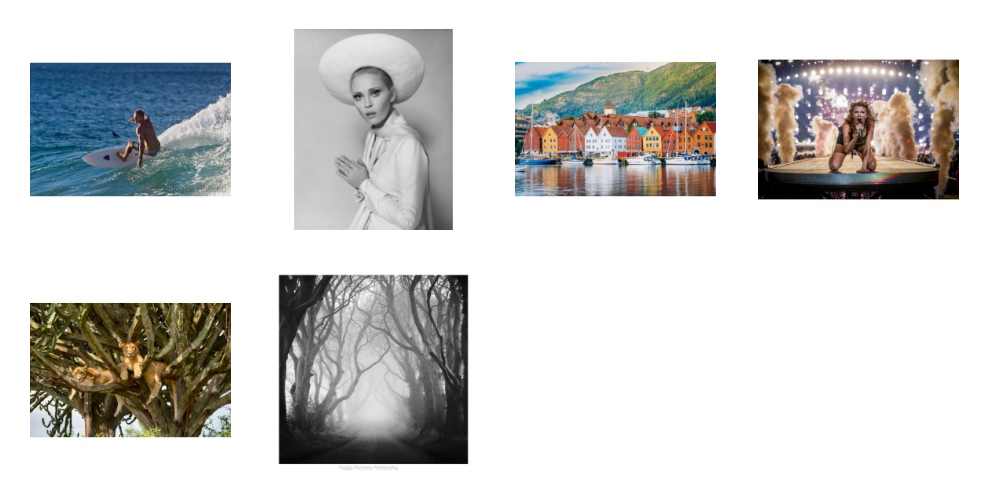

In [5]:
plotImages(val_set[0]['image'][94:100], (4, 4), 300)

In [18]:
def convertToNormal(batches):
    for batch in batches:
        for key, item in batch.items():
            if type(item) == dict:
                for k, v in item.items():
                    batch[key][k] = jnp.array(v)
            else:
                batch[key] = jnp.array(item)
    return batches

In [22]:
n = convertToNormal(val_set)
import pickle
pickle.dump(n, open("val_set.pkl", "wb"))